In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, Conv2DTranspose, Input, Activation, MaxPooling2D, Add, BatchNormalization, Reshape
from keras.models import Model
from keras.initializers import TruncatedNormal
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import random
import os
import re
import cv2
from scipy.misc import imread, imresize
from sklearn.utils import shuffle
%matplotlib inline

In [0]:
input_shape = (160,480,3)
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [0]:
# Reference for model architecture: https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf
def get_FCN32(num_classes):
    # Define a custom intializer
    custom_init = TruncatedNormal(stddev=0.01)
    
    ## Get the block 5 pooling layer from VGG
    pool5 = vgg.get_layer('block5_pool').output

    # Create a convolutionalized version of the first fully connected layer
    fc6 = Conv2D(4096, (7,7), kernel_initializer = custom_init,
               kernel_regularizer = regularizers.l2(0.01), padding='Same')(pool5)

    # Create a convolutionalized version of the second fully connected layer
    fc7 = Conv2D(4096, (1,1), kernel_initializer = custom_init,
               kernel_regularizer = regularizers.l2(0.01), padding='Same')(fc6)

    # Apply a 1x1 onvolution and upsample to the original image shape
    layer_7_1x1 = Conv2D(num_classes, (1,1), kernel_initializer = custom_init,
                 kernel_regularizer = regularizers.l2(0.01), padding='Same')(fc7)
    upsample1 = Conv2DTranspose(num_classes, (64,64), strides = 32, kernel_initializer = custom_init,
               kernel_regularizer = regularizers.l2(0.01), padding='Same')(layer_7_1x1)

    # Add softmax activation
    out_layer = (Activation('softmax'))(upsample1)

    model = Model(vgg.get_layer('input_1').output, out_layer)

    return model

In [4]:
fcn32 = get_FCN32(2)
fcn32.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 480, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 240, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 240, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 240, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 120, 128)      0         
__________

In [0]:
# Compile the Model
adam = Adam(lr = 0.001)
fcn32.compile(optimizer=adam,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [0]:
data_folder = 'data_road/training'

training_images = glob(os.path.join(data_folder, 'image_2', '*.png'))
num_samples = len(training_images)
num_training = int(num_samples*0.8)


def train_generator(data_folder, image_shape, batch_size, training = True):
    image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))[:num_training]
    label_paths = {re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
        for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
    background_color = np.array([255, 0, 0])
    while 1:
        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = imresize(imread(image_file), image_shape)
                gt_image = imresize(imread(gt_image_file), image_shape)

                gt_bg = np.all(gt_image == background_color, axis=2)
                gt_bg = np.expand_dims(gt_bg, axis=2)
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
            
def val_generator(data_folder, image_shape, batch_size, training = True):

    image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))[num_training:]
    label_paths = {re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
        for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
    background_color = np.array([255, 0, 0])
    while 1:
        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = imresize(imread(image_file), image_shape)
                gt_image = imresize(imread(gt_image_file), image_shape)

                gt_bg = np.all(gt_image == background_color, axis=2)
                gt_bg = np.expand_dims(gt_bg, axis=2)
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)

In [8]:
checkpoint = ModelCheckpoint('fcn32_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

batch_size=8
train_generator = train_generator('data_road/training', (160,480), batch_size=batch_size)
val_generator = val_generator('data_road/training', (160,480), batch_size=batch_size, training=False)
fcn32_history = fcn32.fit_generator(train_generator, steps_per_epoch = num_training//batch_size,
                    epochs = 25, verbose = 1, validation_data = val_generator,
                    validation_steps = (num_samples - num_training)//batch_size, callbacks=[checkpoint])

Epoch 1/25


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


28/28 [==============================] - 54s 2s/step - loss: 22.1758 - acc: 0.7103 - val_loss: 3.9288 - val_acc: 0.7965
Epoch 2/25
28/28 [==============================] - 42s 1s/step - loss: 1.7918 - acc: 0.8525 - val_loss: 0.7204 - val_acc: 0.8631
Epoch 3/25
28/28 [==============================] - 38s 1s/step - loss: 0.5669 - acc: 0.8608 - val_loss: 0.4055 - val_acc: 0.8943
Epoch 4/25
28/28 [==============================] - 38s 1s/step - loss: 0.3403 - acc: 0.8976 - val_loss: 0.3505 - val_acc: 0.8703
Epoch 5/25
28/28 [==============================] - 38s 1s/step - loss: 0.2844 - acc: 0.9047 - val_loss: 0.2834 - val_acc: 0.8982
Epoch 6/25
28/28 [==============================] - 38s 1s/step - loss: 0.2952 - acc: 0.9039 - val_loss: 0.3295 - val_acc: 0.8983
Epoch 7/25
28/28 [==============================] - 38s 1s/step - loss: 0.2602 - acc: 0.9132 - val_loss: 0.2557 - val_acc: 0.9130
Epoch 8/25
 4/28 [===>..........................] - ETA: 30s - loss: 0.2385 - acc: 0.917628/28 [====

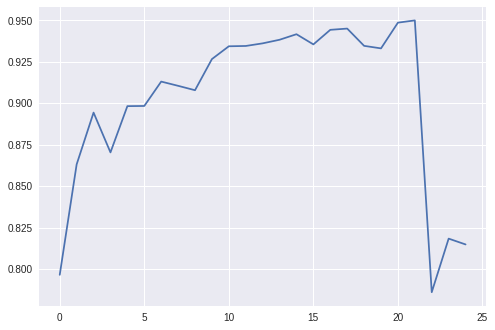

In [23]:
plt.plot(fcn32_history.history['val_acc']);

In [0]:
fcn32.load_weights('fcn32_weights.h5')

/Users/Jheater/Applications/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/Jheater/Applications/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


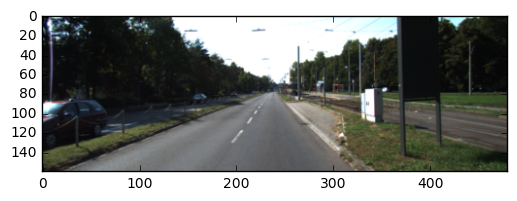

In [3]:
test_image = imresize(imread('data_road/testing/image_2/um_000000.png'), (160,480))
plt.grid('off')
plt.imshow(test_image);

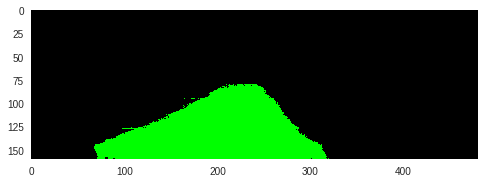

In [12]:
pred = fcn32.predict(test_image.reshape(1,160,480,3))
mask = np.dstack((np.zeros_like(pred[0,:,:,0]),
                 np.round(pred[0,:,:,1]),
                 np.zeros_like(pred[0,:,:,0])))
plt.grid('off')
plt.imshow(mask.astype('uint8')*255);

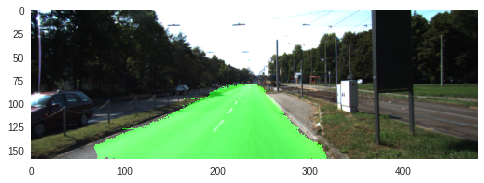

In [14]:
import cv2
output = cv2.addWeighted(test_image, 1.0, mask.astype('uint8')*255, 0.6, 0)
plt.grid('off')
plt.imshow(output)

/Users/Jheater/Applications/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/Jheater/Applications/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


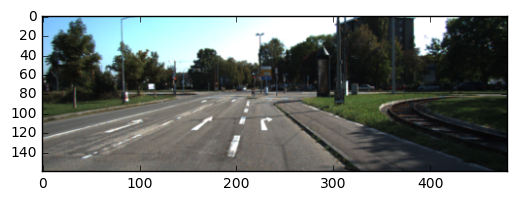

In [4]:
test_image = imresize(imread('data_road/testing/image_2/umm_000002.png'), (160,480))
plt.grid('off')
plt.imshow(test_image);

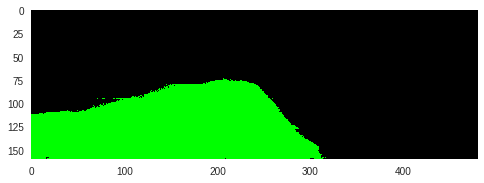

In [19]:
pred = fcn32.predict(test_image.reshape(1,160,480,3))
mask = np.dstack((np.zeros_like(pred[0,:,:,0]),
                 np.round(pred[0,:,:,1]),
                 np.zeros_like(pred[0,:,:,0])))
plt.grid('off')
plt.imshow(mask.astype('uint8')*255);

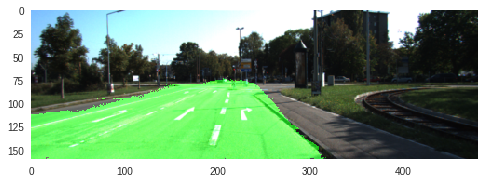

In [20]:
output = cv2.addWeighted(test_image, 1.0, mask.astype('uint8')*255, 0.6, 0)
plt.grid('off')
plt.imshow(output)